In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from utils.utils import *
from utils.utils_synthetic import *
import utils.HTC_utils as HTC
import utils.dyngdim.dyngdim as dyngdim
from utils.dyngdim.plotting import compute_dim_max, plot_results

import random

import networkx as nx

import seaborn as sns

#import os
#os.environ["OPENBLAS_NUM_THREADS"] = "30"
#os.environ['NUMBA_NUM_THREADS'] = "30"

cs = ['b', 'orange']

import warnings
warnings.filterwarnings('ignore')

/home/barzon/.local/lib/python3.8/site-packages/numba/core/errors.py:175: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


# General utils

In [2]:
def simulate_topo_crit_relation(name, info_network,
                                k_min, k_max, n_k,
                                other_min, other_max, n_other,
                                t_min, t_max, n_t,
                                to_save=True, t_store=None, simulate_HTC=False):
    print(f'--------------- {name} ---------------')

    # Create directory name
    directory_name = directory_main + name + '/'
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)

    # Create useful arrays
    times = np.logspace(t_min, t_max, n_t)
    k_params = np.logspace(np.log10(k_min), np.log10(k_max), n_k)
    #k_params = np.linspace(k_min, k_max, n_k, endpoint=True)
    other_params = np.logspace(np.log10(other_min), np.log10(other_max), n_other)

    print('k_params:', k_params)
    print('other_params:', other_params)
    print('')

    params = np.dstack(np.meshgrid(k_params, other_params)).reshape(-1, 2)
    params = params[np.lexsort((params[:,1], params[:, 0])), :] # sort by degree

    ress_htc = []
    ress_dim = []
    ress_mat = []
    ress_dim_extended = []

    for idx, (kavg, other) in enumerate(params):
        print(f'[*] {idx+1}/{len(params)} k={round(kavg, 2)} - other={round(other, 2)}')
    
        ### Create mat
        mat = None
        while mat is None:
            mat = create_network(name, kavg, other, info_network)
        
        ### Simulate HTC model
        if simulate_HTC:
            print('Simulating HTC...')
            tmp_htc = HTC.run_htc(mat, r1, r2, Tmin, Tmax, nT, steps, eq_steps, runs, step_clust=0,
                  norm=True, Tdiv_log=False, display=False, hysteresis=True)
    
        ### Compute dimensionality
        print('Computing dimensionality...')
        local_dimensions = dyngdim.run_local_dimension(nx.from_numpy_array(mat/mat.max()), times, n_workers=n_workers, use_spectral_gap=use_spectral_gap)
        #dim, dim_all = plot_results(times, local_dimensions, mat)
        if t_store is None:
            dim, dim_all = compute_dim_max(local_dimensions)
        else:
            idx_to_store = np.argmin( np.abs(times-t_store) )
            dim_all = local_dimensions[idx_to_store]
            dim = np.nanmean(dim_all)
        print('dim=', dim)
    
        ### Store mat + HTC results
        if to_save:
            fname = f'N_{mat.shape[0]}_k_{kavg}_other_{other}.npy'
            if simulate_HTC:
                np.save(directory_name+'htc_'+fname, tmp_htc)
            np.save(directory_name+'mat_'+fname, mat)
            np.save(directory_name+'dim_'+fname, dim_all)
    
        if simulate_HTC:
            ress_htc.append(tmp_htc)
        ress_dim.append(dim)
        ress_mat.append(mat)
        ress_dim_extended.append(np.nanmean(local_dimensions, axis=1))
    
    ### Store all dimensions
    df = pd.DataFrame(np.vstack([params[:,0], params[:,1], ress_dim]).T, columns=['k','other','dim'])
    df.to_csv(directory_main+name+f'_N_{mat.shape[0]}_'+'dims.csv', index=False)
    
    return (ress_dim, ress_dim_extended, ress_htc)

In [3]:
### General parameters
directory_main = 'results/synthetic_networks/'
N = 200
n_k = 25
n_other = 25

use_spectral_gap = True

# Dimensionality
n_t = 50
n_workers = 50

# SBM

In [34]:
### Params SBM
name = 'SBM'

# Structural params
L = 4
M = N // L

info_network = {'L': L, 'M': M}

# Ranges
k_min = 4
k_max = 30

other_min = 0.01
other_max = 1.

# Dimensionality params
t_min = -3
t_max = 1

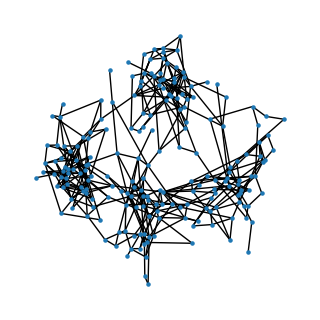

Computing dimensionality...


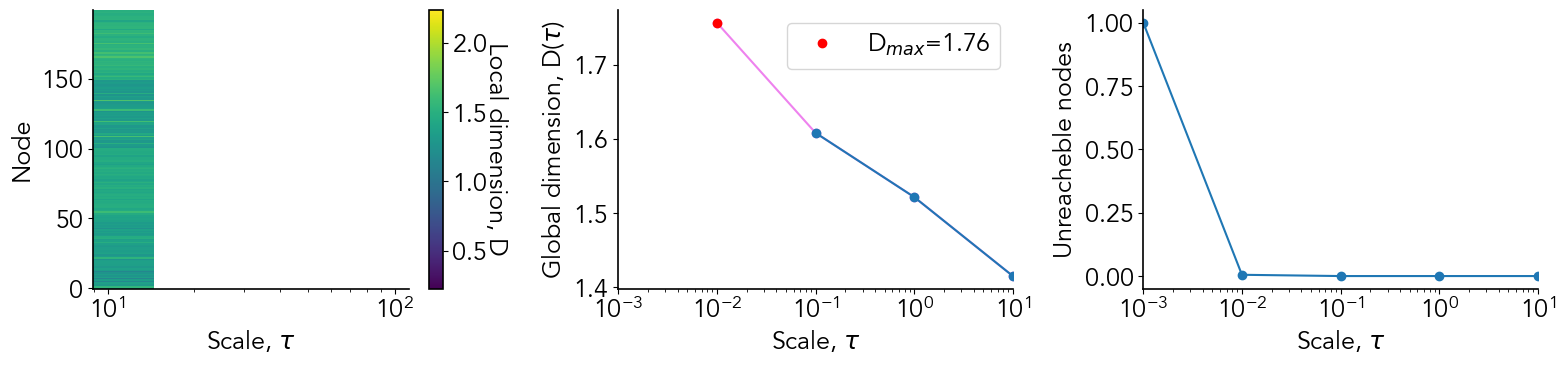

In [32]:
show_example(name, info_network, k_min, other_min, t_min, t_max, simulate_HTC=False)

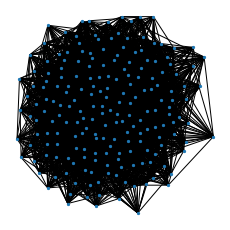

Computing dimensionality...


100%|██████████| 200/200 [00:00<00:00, 394.15it/s]


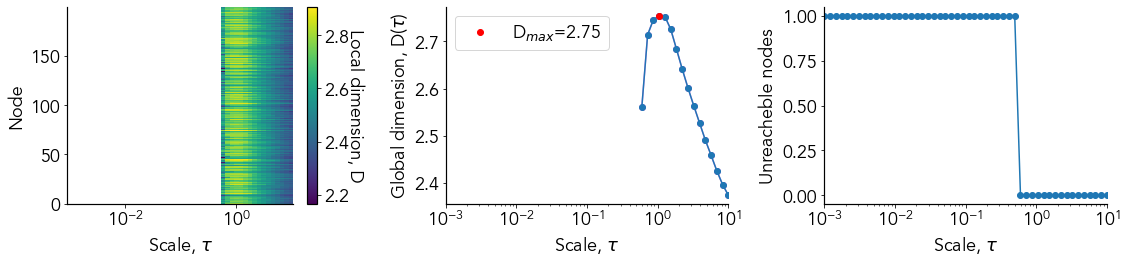

In [8]:
show_example(name, info_network, k_max, other_max, t_min, t_max, simulate_HTC=False)

In [8]:
ress_sbm = simulate_topo_crit_relation(name, info_network,
                                       k_min, k_max, n_k,
                                       other_min, other_max, n_other,
                                       t_min, t_max, n_t,
                                       to_save=True, t_store=None, simulate_HTC=False)

--------------- SBM ---------------
k_params: [ 4.          4.35031673  4.73131391  5.14567851  5.59633283  6.08645508
  6.61950184  7.1992324   7.82973528  8.51545709  9.26123386 10.07232515
 10.95445115 11.91383302 12.95723678 14.09202098 15.32618865 16.66844372
 18.12825238 19.7159099  21.44261317 23.32053969 25.36293349 27.58419846
 30.        ]
other_params: [0.01       0.01211528 0.01467799 0.01778279 0.02154435 0.02610157
 0.03162278 0.03831187 0.04641589 0.05623413 0.06812921 0.08254042
 0.1        0.12115277 0.14677993 0.17782794 0.21544347 0.26101572
 0.31622777 0.38311868 0.46415888 0.56234133 0.68129207 0.82540419
 1.        ]

[*] 1/625 k=4.0 - other=0.01
Computing dimensionality...
dim= 1.4696100551108509
[*] 2/625 k=4.0 - other=0.01
Computing dimensionality...
dim= 1.5219290218778565
[*] 3/625 k=4.0 - other=0.01
Computing dimensionality...
dim= 1.4760084045183377
[*] 4/625 k=4.0 - other=0.02
Computing dimensionality...
dim= 1.5015623257339863
[*] 5/625 k=4.0 - other=0.02

dim= 1.965419938069133
[*] 93/625 k=5.15 - other=0.26
Computing dimensionality...
dim= 1.9786522097301844
[*] 94/625 k=5.15 - other=0.32
Computing dimensionality...
dim= 1.9376430448225757
[*] 95/625 k=5.15 - other=0.38
Computing dimensionality...
dim= 1.9848484891144726
[*] 96/625 k=5.15 - other=0.46
Computing dimensionality...
dim= 1.9496625926471989
[*] 97/625 k=5.15 - other=0.56
Computing dimensionality...
dim= 1.9794571689033722
[*] 98/625 k=5.15 - other=0.68
Computing dimensionality...
dim= 1.9970956690529733
[*] 99/625 k=5.15 - other=0.83
Computing dimensionality...
dim= 2.01514962693498
[*] 100/625 k=5.15 - other=1.0
Computing dimensionality...
dim= 2.023456042313256
[*] 101/625 k=5.6 - other=0.01
Computing dimensionality...
dim= 1.6471914943384143
[*] 102/625 k=5.6 - other=0.01
Computing dimensionality...
dim= 1.6085212849458304
[*] 103/625 k=5.6 - other=0.01
Computing dimensionality...
dim= 1.3885095890829504
[*] 104/625 k=5.6 - other=0.02
Computing dimensionality...
dim= 1.6

dim= 2.024195854091497
[*] 192/625 k=7.2 - other=0.22
Computing dimensionality...
dim= 2.06811279324786
[*] 193/625 k=7.2 - other=0.26
Computing dimensionality...
dim= 2.113592946493544
[*] 194/625 k=7.2 - other=0.32
Computing dimensionality...
dim= 2.125722764213734
[*] 195/625 k=7.2 - other=0.38
Computing dimensionality...
dim= 2.153470076605525
[*] 196/625 k=7.2 - other=0.46
Computing dimensionality...
dim= 2.132607431860424
[*] 197/625 k=7.2 - other=0.56
Computing dimensionality...
dim= 2.14099505343936
[*] 198/625 k=7.2 - other=0.68
Computing dimensionality...
dim= 2.1452534734420685
[*] 199/625 k=7.2 - other=0.83
Computing dimensionality...
dim= 2.1481859051771868
[*] 200/625 k=7.2 - other=1.0
Computing dimensionality...
dim= 2.170011321919467
[*] 201/625 k=7.83 - other=0.01
Computing dimensionality...
dim= 1.7582051575098618
[*] 202/625 k=7.83 - other=0.01
Computing dimensionality...
dim= 1.7688672816349162
[*] 203/625 k=7.83 - other=0.01
Computing dimensionality...
dim= 1.76866

dim= 2.1368849529247083
[*] 291/625 k=10.07 - other=0.18
Computing dimensionality...
dim= 2.1470026717123916
[*] 292/625 k=10.07 - other=0.22
Computing dimensionality...
dim= 2.208811665184397
[*] 293/625 k=10.07 - other=0.26
Computing dimensionality...
dim= 2.218943036041342
[*] 294/625 k=10.07 - other=0.32
Computing dimensionality...
dim= 2.264556579633557
[*] 295/625 k=10.07 - other=0.38
Computing dimensionality...
dim= 2.2520963497208997
[*] 296/625 k=10.07 - other=0.46
Computing dimensionality...
dim= 2.282649778725829
[*] 297/625 k=10.07 - other=0.56
Computing dimensionality...
dim= 2.316124365628926
[*] 298/625 k=10.07 - other=0.68
Computing dimensionality...
dim= 2.3068654751729203
[*] 299/625 k=10.07 - other=0.83
Computing dimensionality...
dim= 2.3142755268683093
[*] 300/625 k=10.07 - other=1.0
Computing dimensionality...
dim= 2.326074133635359
[*] 301/625 k=10.95 - other=0.01
Computing dimensionality...
dim= 1.903055090635654
[*] 302/625 k=10.95 - other=0.01
Computing dimens

dim= 2.1814772560993982
[*] 389/625 k=14.09 - other=0.12
Computing dimensionality...
dim= 2.203884663347076
[*] 390/625 k=14.09 - other=0.15
Computing dimensionality...
dim= 2.243656257878978
[*] 391/625 k=14.09 - other=0.18
Computing dimensionality...
dim= 2.2887817497165317
[*] 392/625 k=14.09 - other=0.22
Computing dimensionality...
dim= 2.2993580442071635
[*] 393/625 k=14.09 - other=0.26
Computing dimensionality...
dim= 2.3450362138803578
[*] 394/625 k=14.09 - other=0.32
Computing dimensionality...
dim= 2.3779445882709807
[*] 395/625 k=14.09 - other=0.38
Computing dimensionality...
dim= 2.381756589152364
[*] 396/625 k=14.09 - other=0.46
Computing dimensionality...
dim= 2.42348711917324
[*] 397/625 k=14.09 - other=0.56
Computing dimensionality...
dim= 2.415832104901477
[*] 398/625 k=14.09 - other=0.68
Computing dimensionality...
dim= 2.4397510125531614
[*] 399/625 k=14.09 - other=0.83
Computing dimensionality...
dim= 2.4451662226175994
[*] 400/625 k=14.09 - other=1.0
Computing dimen

dim= 2.1881833609628654
[*] 486/625 k=19.72 - other=0.07
Computing dimensionality...
dim= 2.2018112939315175
[*] 487/625 k=19.72 - other=0.08
Computing dimensionality...
dim= 2.2367929769602317
[*] 488/625 k=19.72 - other=0.1
Computing dimensionality...
dim= 2.2906336178993842
[*] 489/625 k=19.72 - other=0.12
Computing dimensionality...
dim= 2.2872740911256297
[*] 490/625 k=19.72 - other=0.15
Computing dimensionality...
dim= 2.3447769246142824
[*] 491/625 k=19.72 - other=0.18
Computing dimensionality...
dim= 2.3721096554979066
[*] 492/625 k=19.72 - other=0.22
Computing dimensionality...
dim= 2.4051394872935608
[*] 493/625 k=19.72 - other=0.26
Computing dimensionality...
dim= 2.431806751745215
[*] 494/625 k=19.72 - other=0.32
Computing dimensionality...
dim= 2.4535071790538647
[*] 495/625 k=19.72 - other=0.38
Computing dimensionality...
dim= 2.5258534873913625
[*] 496/625 k=19.72 - other=0.46
Computing dimensionality...
dim= 2.5451187485080173
[*] 497/625 k=19.72 - other=0.56
Computing 

dim= 2.1981816398405023
[*] 583/625 k=27.58 - other=0.04
Computing dimensionality...
dim= 2.225593762948933
[*] 584/625 k=27.58 - other=0.05
Computing dimensionality...
dim= 2.2251392519621165
[*] 585/625 k=27.58 - other=0.06
Computing dimensionality...
dim= 2.2564677048970325
[*] 586/625 k=27.58 - other=0.07
Computing dimensionality...
dim= 2.2932528420715266
[*] 587/625 k=27.58 - other=0.08
Computing dimensionality...
dim= 2.3088716027589
[*] 588/625 k=27.58 - other=0.1
Computing dimensionality...
dim= 2.352089622085101
[*] 589/625 k=27.58 - other=0.12
Computing dimensionality...
dim= 2.477950127951267
[*] 590/625 k=27.58 - other=0.15
Computing dimensionality...
dim= 2.45821709108551
[*] 591/625 k=27.58 - other=0.18
Computing dimensionality...
dim= 2.4628736979276398
[*] 592/625 k=27.58 - other=0.22
Computing dimensionality...
dim= 2.5089419627863148
[*] 593/625 k=27.58 - other=0.26
Computing dimensionality...
dim= 2.572672976844089
[*] 594/625 k=27.58 - other=0.32
Computing dimensio

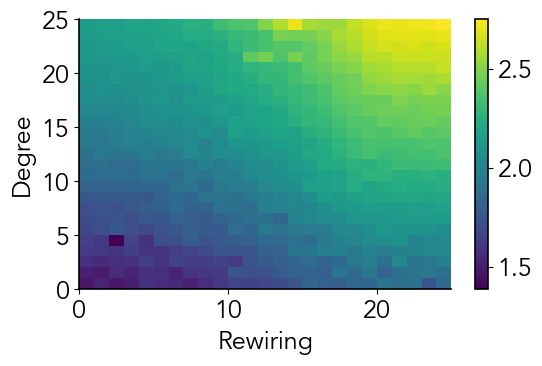

In [10]:
ress_dim = np.array(ress_sbm[0]).reshape(n_k, n_other)

plt.pcolormesh(ress_dim)
plt.colorbar()
plt.xlabel('Rewiring')
plt.ylabel('Degree')
plt.show()

# Small world

In [11]:
### Params SBM
name = 'SW'

# Structural params
L = 4
M = N // L

info_network = {'L': L, 'M': M}

# Ranges
k_min = 4
k_max = 30

other_min = 0.01
other_max = 1.

# Dimensionality params
t_min = -3
t_max = 1

In [ ]:
show_example(name, info_network, k_min, other_min, t_min, t_max, simulate_HTC=False)

In [ ]:
show_example(name, info_network, k_max, other_max, t_min, t_max, simulate_HTC=False)

In [12]:
ress_sw = simulate_topo_crit_relation(name, info_network,
                                       k_min, k_max, n_k,
                                       other_min, other_max, n_other,
                                       t_min, t_max, n_t,
                                       to_save=True, t_store=None, simulate_HTC=False)

--------------- SW ---------------
k_params: [ 4.          4.35031673  4.73131391  5.14567851  5.59633283  6.08645508
  6.61950184  7.1992324   7.82973528  8.51545709  9.26123386 10.07232515
 10.95445115 11.91383302 12.95723678 14.09202098 15.32618865 16.66844372
 18.12825238 19.7159099  21.44261317 23.32053969 25.36293349 27.58419846
 30.        ]
other_params: [0.01       0.01211528 0.01467799 0.01778279 0.02154435 0.02610157
 0.03162278 0.03831187 0.04641589 0.05623413 0.06812921 0.08254042
 0.1        0.12115277 0.14677993 0.17782794 0.21544347 0.26101572
 0.31622777 0.38311868 0.46415888 0.56234133 0.68129207 0.82540419
 1.        ]

[*] 1/625 k=4.0 - other=0.01
Computing dimensionality...
dim= 1.184761754546039
[*] 2/625 k=4.0 - other=0.01
Computing dimensionality...
dim= 1.0923136643509792
[*] 3/625 k=4.0 - other=0.01
Computing dimensionality...
dim= 1.1314112404496104
[*] 4/625 k=4.0 - other=0.02
Computing dimensionality...
dim= 1.110167987269287
[*] 5/625 k=4.0 - other=0.02
Co

dim= 1.5755195445688241
[*] 93/625 k=5.15 - other=0.26
Computing dimensionality...
dim= 1.5915929304988758
[*] 94/625 k=5.15 - other=0.32
Computing dimensionality...
dim= 1.6903971518481407
[*] 95/625 k=5.15 - other=0.38
Computing dimensionality...
dim= 1.7594166573636034
[*] 96/625 k=5.15 - other=0.46
Computing dimensionality...
dim= 1.7882442811252102
[*] 97/625 k=5.15 - other=0.56
Computing dimensionality...
dim= 1.7871020893582275
[*] 98/625 k=5.15 - other=0.68
Computing dimensionality...
dim= 1.797043608175751
[*] 99/625 k=5.15 - other=0.83
Computing dimensionality...
dim= 1.8617410407266004
[*] 100/625 k=5.15 - other=1.0
Computing dimensionality...
dim= 1.8302145583411382
[*] 101/625 k=5.6 - other=0.01
Computing dimensionality...
dim= 1.1078275219590086
[*] 102/625 k=5.6 - other=0.01
Computing dimensionality...
dim= 1.1443303895227728
[*] 103/625 k=5.6 - other=0.01
Computing dimensionality...
dim= 1.2498390478839996
[*] 104/625 k=5.6 - other=0.02
Computing dimensionality...
dim= 

dim= 1.709472960217805
[*] 192/625 k=7.2 - other=0.22
Computing dimensionality...
dim= 1.848952934613014
[*] 193/625 k=7.2 - other=0.26
Computing dimensionality...
dim= 1.8250886182166517
[*] 194/625 k=7.2 - other=0.32
Computing dimensionality...
dim= 1.9149911730383247
[*] 195/625 k=7.2 - other=0.38
Computing dimensionality...
dim= 2.0012417634380575
[*] 196/625 k=7.2 - other=0.46
Computing dimensionality...
dim= 2.011165482089826
[*] 197/625 k=7.2 - other=0.56
Computing dimensionality...
dim= 2.041719110057684
[*] 198/625 k=7.2 - other=0.68
Computing dimensionality...
dim= 2.0961850841452287
[*] 199/625 k=7.2 - other=0.83
Computing dimensionality...
dim= 2.076053839098808
[*] 200/625 k=7.2 - other=1.0
Computing dimensionality...
dim= 2.0707616123456125
[*] 201/625 k=7.83 - other=0.01
Computing dimensionality...
dim= 1.272689792840549
[*] 202/625 k=7.83 - other=0.01
Computing dimensionality...
dim= 1.2771515884001556
[*] 203/625 k=7.83 - other=0.01
Computing dimensionality...
dim= 1.2

dim= 1.8611843656051934
[*] 290/625 k=10.07 - other=0.15
Computing dimensionality...
dim= 1.922082266206246
[*] 291/625 k=10.07 - other=0.18
Computing dimensionality...
dim= 1.9913008154350809
[*] 292/625 k=10.07 - other=0.22
Computing dimensionality...
dim= 2.0378651464726873
[*] 293/625 k=10.07 - other=0.26
Computing dimensionality...
dim= 2.055174695689623
[*] 294/625 k=10.07 - other=0.32
Computing dimensionality...
dim= 2.096685633991201
[*] 295/625 k=10.07 - other=0.38
Computing dimensionality...
dim= 2.199286342183691
[*] 296/625 k=10.07 - other=0.46
Computing dimensionality...
dim= 2.2505960729866636
[*] 297/625 k=10.07 - other=0.56
Computing dimensionality...
dim= 2.2796320792791556
[*] 298/625 k=10.07 - other=0.68
Computing dimensionality...
dim= 2.29652169391713
[*] 299/625 k=10.07 - other=0.83
Computing dimensionality...
dim= 2.3075394820485804
[*] 300/625 k=10.07 - other=1.0
Computing dimensionality...
dim= 2.317645566537732
[*] 301/625 k=10.95 - other=0.01
Computing dimens

dim= 1.8643738736451627
[*] 387/625 k=14.09 - other=0.08
Computing dimensionality...
dim= 1.897253649556681
[*] 388/625 k=14.09 - other=0.1
Computing dimensionality...
dim= 2.011422085264705
[*] 389/625 k=14.09 - other=0.12
Computing dimensionality...
dim= 1.9626801900377535
[*] 390/625 k=14.09 - other=0.15
Computing dimensionality...
dim= 2.0201670830191647
[*] 391/625 k=14.09 - other=0.18
Computing dimensionality...
dim= 2.065229427054392
[*] 392/625 k=14.09 - other=0.22
Computing dimensionality...
dim= 2.1002631954103776
[*] 393/625 k=14.09 - other=0.26
Computing dimensionality...
dim= 2.1856160192590455
[*] 394/625 k=14.09 - other=0.32
Computing dimensionality...
dim= 2.2459911506612706
[*] 395/625 k=14.09 - other=0.38
Computing dimensionality...
dim= 2.320221359052086
[*] 396/625 k=14.09 - other=0.46
Computing dimensionality...
dim= 2.350511827247268
[*] 397/625 k=14.09 - other=0.56
Computing dimensionality...
dim= 2.3929491791599196
[*] 398/625 k=14.09 - other=0.68
Computing dime

dim= 1.9105110175796254
[*] 484/625 k=19.72 - other=0.05
Computing dimensionality...
dim= 1.950753575395252
[*] 485/625 k=19.72 - other=0.06
Computing dimensionality...
dim= 2.0043331798654545
[*] 486/625 k=19.72 - other=0.07
Computing dimensionality...
dim= 1.976267004514866
[*] 487/625 k=19.72 - other=0.08
Computing dimensionality...
dim= 2.0149292719343994
[*] 488/625 k=19.72 - other=0.1
Computing dimensionality...
dim= 2.1132837026337508
[*] 489/625 k=19.72 - other=0.12
Computing dimensionality...
dim= 2.1403091243359476
[*] 490/625 k=19.72 - other=0.15
Computing dimensionality...
dim= 2.153051302496372
[*] 491/625 k=19.72 - other=0.18
Computing dimensionality...
dim= 2.2785501401390955
[*] 492/625 k=19.72 - other=0.22
Computing dimensionality...
dim= 2.237190385973267
[*] 493/625 k=19.72 - other=0.26
Computing dimensionality...
dim= 2.2902147747359636
[*] 494/625 k=19.72 - other=0.32
Computing dimensionality...
dim= 2.350682679740464
[*] 495/625 k=19.72 - other=0.38
Computing dime

dim= 2.0905683326448177
[*] 582/625 k=27.58 - other=0.03
Computing dimensionality...
dim= 2.1432047054637877
[*] 583/625 k=27.58 - other=0.04
Computing dimensionality...
dim= 2.1512614457104413
[*] 584/625 k=27.58 - other=0.05
Computing dimensionality...
dim= 2.2084595590696017
[*] 585/625 k=27.58 - other=0.06
Computing dimensionality...
dim= 2.1754922795350136
[*] 586/625 k=27.58 - other=0.07
Computing dimensionality...
dim= 2.1990053694658984
[*] 587/625 k=27.58 - other=0.08
Computing dimensionality...
dim= 2.258624781542538
[*] 588/625 k=27.58 - other=0.1
Computing dimensionality...
dim= 2.3175054030894287
[*] 589/625 k=27.58 - other=0.12
Computing dimensionality...
dim= 2.3302118830567164
[*] 590/625 k=27.58 - other=0.15
Computing dimensionality...
dim= 2.4008017544387634
[*] 591/625 k=27.58 - other=0.18
Computing dimensionality...
dim= 2.5384275256280366
[*] 592/625 k=27.58 - other=0.22
Computing dimensionality...
dim= 2.4872939369834044
[*] 593/625 k=27.58 - other=0.26
Computing 

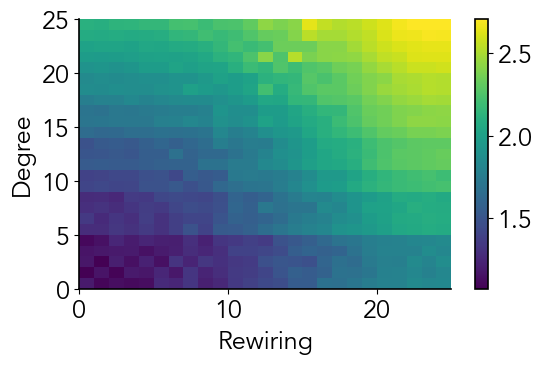

In [14]:
ress_dim = np.array(ress_sw[0]).reshape(n_k, n_other)

plt.pcolormesh(ress_dim)
plt.colorbar()
plt.xlabel('Rewiring')
plt.ylabel('Degree')
plt.show()

# Weight heterogeneity

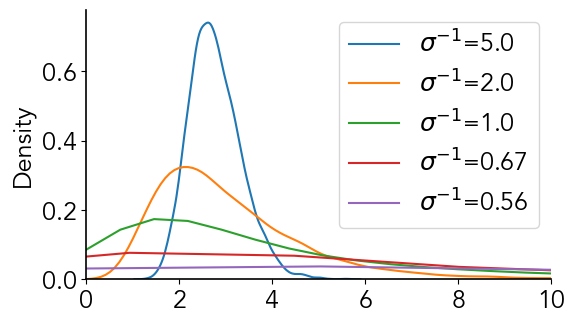

In [24]:
sigmas = [0.2, 0.5, 1, 1.5, 1.8]
mu = 1

T = int(1e4)

for sigma in sigmas:
    #mu_real, sigma_real = params_lognormal(mu, sigma)
    #weight = np.random.lognormal(mu_real, sigma_real, size=T)
    weight = np.random.lognormal(mu, sigma, size=T)
    sns.kdeplot(weight, label=r'$\sigma^{-1}$='+str(round(1/sigma,2)))
plt.xlim(0,int(1e1))
#plt.yscale('log')
plt.legend()
plt.show()

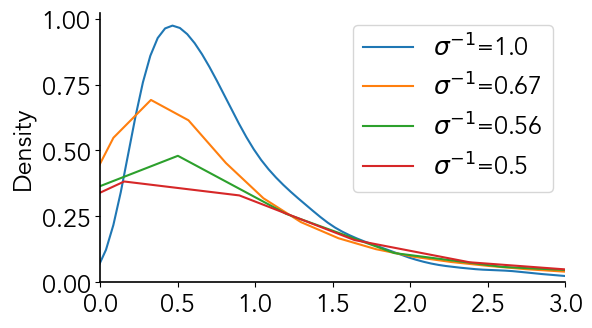

In [20]:
sigmas = [1, 1.5, 1.8, 2]
mu = 1

T = int(1e4)

for sigma in sigmas:
    mu_real, sigma_real = params_lognormal(mu, sigma)
    weight = np.random.lognormal(mu_real, sigma_real, size=T)
    #weight = np.random.lognormal(mu, sigma, size=T)
    sns.kdeplot(weight, label=r'$\sigma^{-1}$='+str(round(1/sigma,2)))
plt.xlim(0,int(3e0))
#plt.yscale('log')
plt.legend()
plt.show()

In [22]:
### Params SBM
name = 'WW'

# Structural params
info_network = {}

# Ranges
k_min = 4
k_max = 30

other_min = 1/2.
other_max = 1/1

# Dimensionality params
t_min = -2
t_max = 1

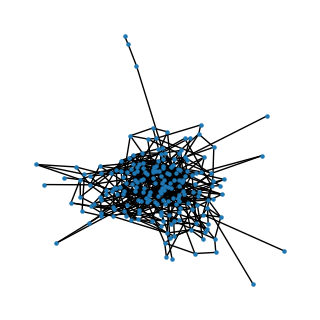

Computing dimensionality...


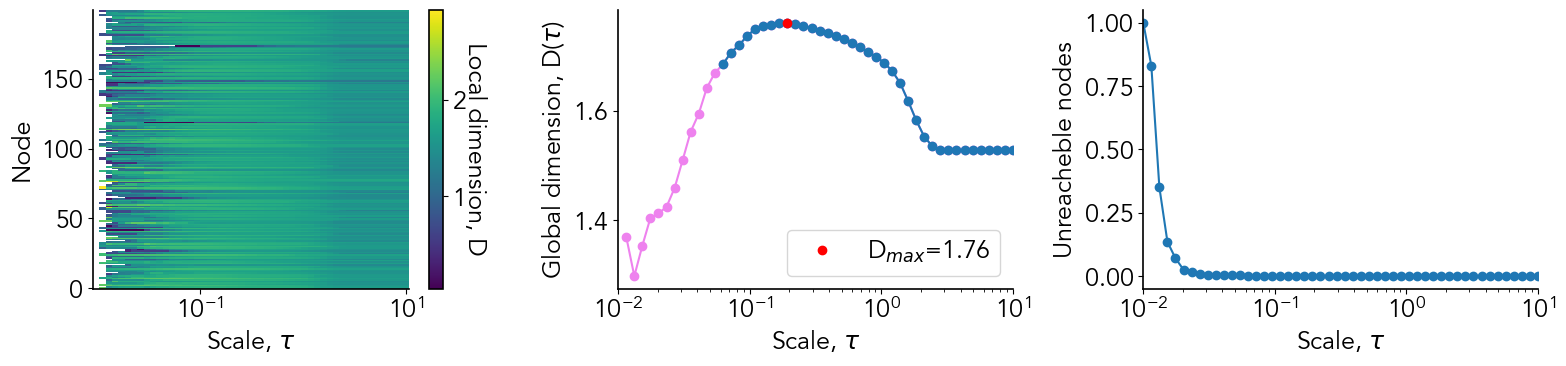

In [10]:
show_example(name, info_network, k_min, other_min, t_min, t_max, simulate_HTC=False)

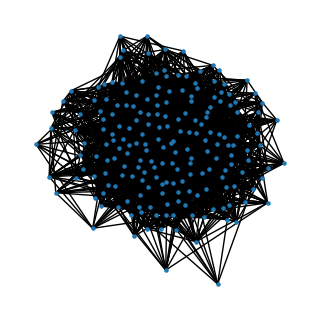

Computing dimensionality...


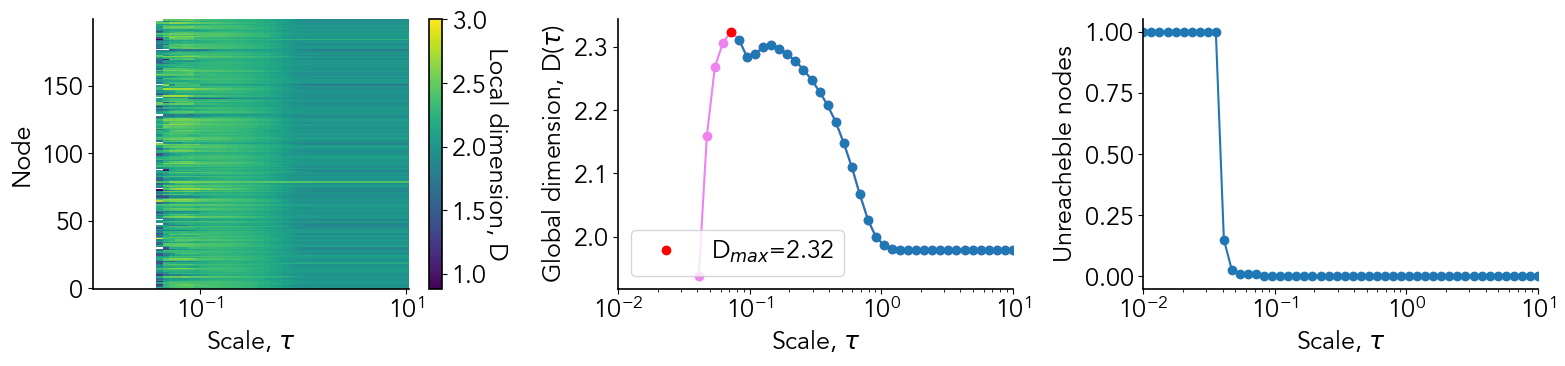

In [11]:
show_example(name, info_network, k_max, other_min, t_min, t_max, simulate_HTC=False)

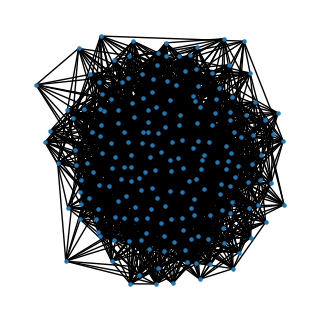

Computing dimensionality...


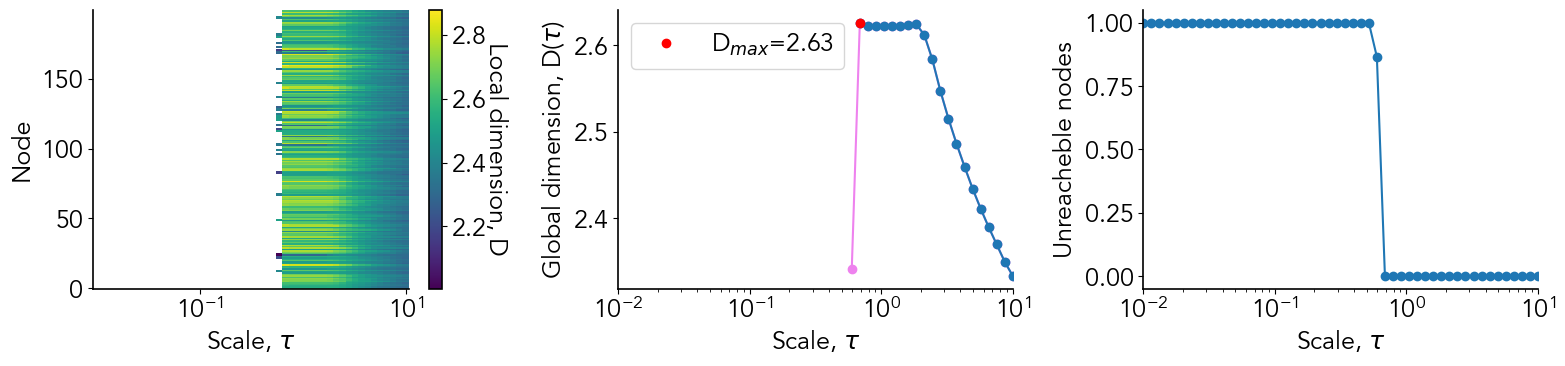

In [12]:
show_example(name, info_network, k_max, other_max, t_min, t_max, simulate_HTC=False)

In [27]:
ress_ww = simulate_topo_crit_relation(name, info_network,
                                       k_min, k_max, n_k,
                                       other_min, other_max, n_other,
                                       t_min, t_max, n_t,
                                       to_save=True, t_store=None, simulate_HTC=False)

--------------- WW ---------------
k_params: [ 4.          4.35031673  4.73131391  5.14567851  5.59633283  6.08645508
  6.61950184  7.1992324   7.82973528  8.51545709  9.26123386 10.07232515
 10.95445115 11.91383302 12.95723678 14.09202098 15.32618865 16.66844372
 18.12825238 19.7159099  21.44261317 23.32053969 25.36293349 27.58419846
 30.        ]
other_params: [0.5        0.51465112 0.52973155 0.54525387 0.56123102 0.57767635
 0.59460356 0.61202677 0.62996052 0.64841978 0.66741993 0.68697682
 0.70710678 0.72782659 0.74915354 0.77110541 0.79370053 0.81695773
 0.84089642 0.86553656 0.89089872 0.91700404 0.94387431 0.97153194
 1.        ]

[*] 1/625 k=4.0 - other=0.5
Computing dimensionality...
dim= 1.6575879845393484
[*] 2/625 k=4.0 - other=0.51
Computing dimensionality...
dim= 1.7236683475770787
[*] 3/625 k=4.0 - other=0.53
Computing dimensionality...
dim= 1.6552731023095795
[*] 4/625 k=4.0 - other=0.55
Computing dimensionality...
dim= 1.7453995367846573
[*] 5/625 k=4.0 - other=0.56
C

dim= 2.0337983207575765
[*] 93/625 k=5.15 - other=0.82
Computing dimensionality...
dim= 2.0690853216751384
[*] 94/625 k=5.15 - other=0.84
Computing dimensionality...
dim= 2.00047140648723
[*] 95/625 k=5.15 - other=0.87
Computing dimensionality...
dim= 2.028686417206296
[*] 96/625 k=5.15 - other=0.89
Computing dimensionality...
dim= 2.0473455122615447
[*] 97/625 k=5.15 - other=0.92
Computing dimensionality...
dim= 2.0280146159373853
[*] 98/625 k=5.15 - other=0.94
Computing dimensionality...
dim= 2.1223300616788534
[*] 99/625 k=5.15 - other=0.97
Computing dimensionality...
dim= 2.0597895956066283
[*] 100/625 k=5.15 - other=1.0
Computing dimensionality...
dim= 2.0696798501470246
[*] 101/625 k=5.6 - other=0.5
Computing dimensionality...
dim= 1.8729112972448292
[*] 102/625 k=5.6 - other=0.51
Computing dimensionality...
dim= 1.8009570222391107
[*] 103/625 k=5.6 - other=0.53
Computing dimensionality...
dim= 1.8680057765428217
[*] 104/625 k=5.6 - other=0.55
Computing dimensionality...
dim= 1.8

dim= 2.1679830990559563
[*] 192/625 k=7.2 - other=0.79
Computing dimensionality...
dim= 2.176056274391222
[*] 193/625 k=7.2 - other=0.82
Computing dimensionality...
dim= 2.2041449396201807
[*] 194/625 k=7.2 - other=0.84
Computing dimensionality...
dim= 2.219296753095069
[*] 195/625 k=7.2 - other=0.87
Computing dimensionality...
dim= 2.1740022262181538
[*] 196/625 k=7.2 - other=0.89
Computing dimensionality...
dim= 2.231146651403598
[*] 197/625 k=7.2 - other=0.92
Computing dimensionality...
dim= 2.2211541434663
[*] 198/625 k=7.2 - other=0.94
Computing dimensionality...
dim= 2.209836606933028
[*] 199/625 k=7.2 - other=0.97
Computing dimensionality...
dim= 2.2653934657770294
[*] 200/625 k=7.2 - other=1.0
Computing dimensionality...
dim= 2.25380275592278
[*] 201/625 k=7.83 - other=0.5
Computing dimensionality...
dim= 2.0518556168385715
[*] 202/625 k=7.83 - other=0.51
Computing dimensionality...
dim= 1.9956259069525413
[*] 203/625 k=7.83 - other=0.53
Computing dimensionality...
dim= 2.00205

dim= 2.2646513401004658
[*] 291/625 k=10.07 - other=0.77
Computing dimensionality...
dim= 2.307205741321447
[*] 292/625 k=10.07 - other=0.79
Computing dimensionality...
dim= 2.3444872306506053
[*] 293/625 k=10.07 - other=0.82
Computing dimensionality...
dim= 2.3173112629311974
[*] 294/625 k=10.07 - other=0.84
Computing dimensionality...
dim= 2.3514786234685006
[*] 295/625 k=10.07 - other=0.87
Computing dimensionality...
dim= 2.314331608071391
[*] 296/625 k=10.07 - other=0.89
Computing dimensionality...
dim= 2.320271504500587
[*] 297/625 k=10.07 - other=0.92
Computing dimensionality...
dim= 2.354684066240806
[*] 298/625 k=10.07 - other=0.94
Computing dimensionality...
dim= 2.32813487383581
[*] 299/625 k=10.07 - other=0.97
Computing dimensionality...
dim= 2.3574883201456887
[*] 300/625 k=10.07 - other=1.0
Computing dimensionality...
dim= 2.3809065932221545
[*] 301/625 k=10.95 - other=0.5
Computing dimensionality...
dim= 2.153909824814884
[*] 302/625 k=10.95 - other=0.51
Computing dimensi

dim= 2.4114230972256805
[*] 389/625 k=14.09 - other=0.73
Computing dimensionality...
dim= 2.4292339819719375
[*] 390/625 k=14.09 - other=0.75
Computing dimensionality...
dim= 2.4286162772096502
[*] 391/625 k=14.09 - other=0.77
Computing dimensionality...
dim= 2.428312972517534
[*] 392/625 k=14.09 - other=0.79
Computing dimensionality...
dim= 2.43285334466343
[*] 393/625 k=14.09 - other=0.82
Computing dimensionality...
dim= 2.4658576713345237
[*] 394/625 k=14.09 - other=0.84
Computing dimensionality...
dim= 2.4403290572291727
[*] 395/625 k=14.09 - other=0.87
Computing dimensionality...
dim= 2.4612197790645336
[*] 396/625 k=14.09 - other=0.89
Computing dimensionality...
dim= 2.466269671778917
[*] 397/625 k=14.09 - other=0.92
Computing dimensionality...
dim= 2.4461354933567896
[*] 398/625 k=14.09 - other=0.94
Computing dimensionality...
dim= 2.486499129969422
[*] 399/625 k=14.09 - other=0.97
Computing dimensionality...
dim= 2.4873921140474766
[*] 400/625 k=14.09 - other=1.0
Computing dime

dim= 2.5168486403011743
[*] 486/625 k=19.72 - other=0.67
Computing dimensionality...
dim= 2.55301624945694
[*] 487/625 k=19.72 - other=0.69
Computing dimensionality...
dim= 2.5634312949165063
[*] 488/625 k=19.72 - other=0.71
Computing dimensionality...
dim= 2.565665466816191
[*] 489/625 k=19.72 - other=0.73
Computing dimensionality...
dim= 2.5718727274201036
[*] 490/625 k=19.72 - other=0.75
Computing dimensionality...
dim= 2.577687638701727
[*] 491/625 k=19.72 - other=0.77
Computing dimensionality...
dim= 2.561043459844348
[*] 492/625 k=19.72 - other=0.79
Computing dimensionality...
dim= 2.605614280413738
[*] 493/625 k=19.72 - other=0.82
Computing dimensionality...
dim= 2.606411166104151
[*] 494/625 k=19.72 - other=0.84
Computing dimensionality...
dim= 2.6203812398028608
[*] 495/625 k=19.72 - other=0.87
Computing dimensionality...
dim= 2.607219052695458
[*] 496/625 k=19.72 - other=0.89
Computing dimensionality...
dim= 2.628238207357524
[*] 497/625 k=19.72 - other=0.92
Computing dimensi

dim= 2.6102749252523334
[*] 583/625 k=27.58 - other=0.61
Computing dimensionality...
dim= 2.583316968864783
[*] 584/625 k=27.58 - other=0.63
Computing dimensionality...
dim= 2.6592254134975093
[*] 585/625 k=27.58 - other=0.65
Computing dimensionality...
dim= 2.661121599909761
[*] 586/625 k=27.58 - other=0.67
Computing dimensionality...
dim= 2.6680517018220242
[*] 587/625 k=27.58 - other=0.69
Computing dimensionality...
dim= 2.6699143768914264
[*] 588/625 k=27.58 - other=0.71
Computing dimensionality...
dim= 2.6865294969127897
[*] 589/625 k=27.58 - other=0.73
Computing dimensionality...
dim= 2.7063959956005443
[*] 590/625 k=27.58 - other=0.75
Computing dimensionality...
dim= 2.7233737023910907
[*] 591/625 k=27.58 - other=0.77
Computing dimensionality...
dim= 2.7173176887854202
[*] 592/625 k=27.58 - other=0.79
Computing dimensionality...
dim= 2.7123486711941815
[*] 593/625 k=27.58 - other=0.82
Computing dimensionality...
dim= 2.7416924774632765
[*] 594/625 k=27.58 - other=0.84
Computing 

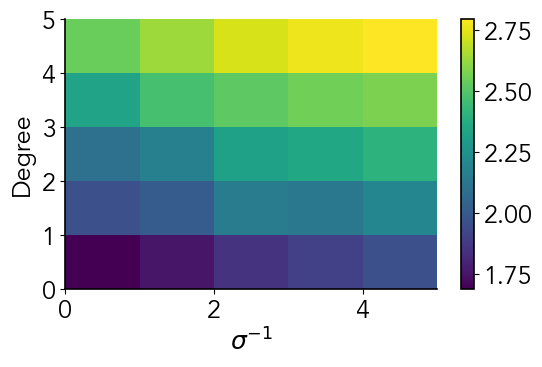

In [25]:
ress_dim = np.array(ress_ww[0]).reshape(n_k, n_other)

plt.pcolormesh(ress_dim)
plt.xlabel(r'$\sigma^{-1}$')
plt.ylabel('Degree')
plt.colorbar()
plt.show()

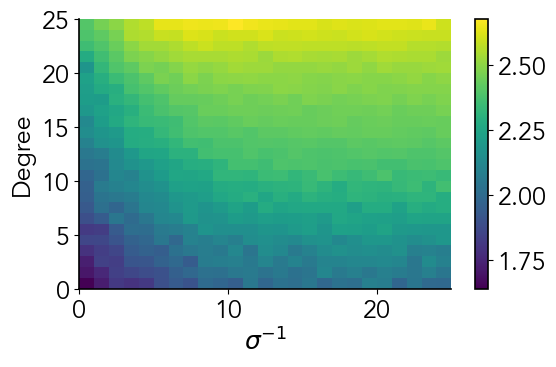

In [14]:
ress_dim = np.array(ress_ww[0]).reshape(n_k, n_other)

plt.pcolormesh(ress_dim)
plt.xlabel(r'$\sigma^{-1}$')
plt.ylabel('Degree')
plt.colorbar()
plt.show()